In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

In [2]:
df = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")

# New Feature 1
term_mapping = {
    'Month-to-month': 1,
    'One year': 12,
    'Two year': 24
}
df['Contract'] = df['Contract'].map(term_mapping)
df['renewed_status'] = df['tenure'] - df['Contract']

# New Feature 2
# Calculate the remaining time for one-year contracts
df.loc[df['Contract'] == 12, 'remaining_time'] = 12 - (df['tenure'] % 12)

# Calculate the remaining time for two-year contracts
df.loc[df['Contract'] == 24, 'remaining_time'] = 24 - (df['tenure'] % 24)

# Determine if the contract is near the end (remaining time <= 1 month)
df['near_contract_end'] = df['remaining_time'].apply(lambda x: 'yes' if x <= 1 else 'no')

# New Feature 3
# Convert 'yes'/'no' in StreamingMovies and StreamingTV to 1/0
df['streaming_movies_int'] = df['StreamingMovies'].apply(lambda x: 1 if x == 'yes' else 0)
df['streaming_tv_int'] = df['StreamingTV'].apply(lambda x: 1 if x == 'yes' else 0)

# Add StreamingMovies and StreamingTV usage
df['streaming_total'] = df['streaming_movies_int'] + df['streaming_tv_int']

# Create a binary indicator for Fiber optic (1 if Fiber optic, 0 otherwise)
df['fiber_optic'] = df['InternetService'].apply(lambda x: 1 if x == 'Fiber optic' else 0)

# Calculate the interaction term
df['internet_streaming_interaction'] = df['fiber_optic'] * df['streaming_total']

#df[df['internet_streaming_interaction']!='0']

#New feature 4
df['auto_bill_Yes'] = df['PaymentMethod'].apply(lambda x: 1 if 'automatic' in x.lower() else 0)
df['PaperlessBilling_Yes'] = df['PaperlessBilling'].apply(lambda x: 1 if x == 'yes' else 0)

df['billing_convenience'] = df.apply(lambda row: 2 if row['auto_bill_Yes'] == 1 and row['PaperlessBilling_Yes'] == 1 
                                     else (1 if row['auto_bill_Yes'] == 1 or row['PaperlessBilling_Yes'] == 1 else 0), axis=1)


In [3]:
Variables_provide_by_Maggie = ['renewed_status', 'near_contract_end', 'internet_streaming_interaction', 'billing_convenience']
Variables_highlighted_by_BSteam = ['SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', \
                                   'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Variables_highlighted_by_Leader = ['tenure', 'TotalCharges', 'MonthlyCharges']

Y_Col = ['Churn']
df_ready = df[list(set(Variables_provide_by_Maggie + Variables_highlighted_by_BSteam + Variables_highlighted_by_Leader + Y_Col))].copy()
df_ready = df_ready[~df_ready['TotalCharges'].isin([' ', '', '  '])]
df_ready[['MonthlyCharges', 'TotalCharges']] = df_ready[['MonthlyCharges', 'TotalCharges']].astype(float)
df_ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Partner                         7032 non-null   object 
 1   Dependents                      7032 non-null   object 
 2   PaperlessBilling                7032 non-null   object 
 3   StreamingMovies                 7032 non-null   object 
 4   SeniorCitizen                   7032 non-null   int64  
 5   tenure                          7032 non-null   int64  
 6   renewed_status                  7032 non-null   int64  
 7   TotalCharges                    7032 non-null   float64
 8   billing_convenience             7032 non-null   int64  
 9   near_contract_end               7032 non-null   object 
 10  InternetService                 7032 non-null   object 
 11  TechSupport                     7032 non-null   object 
 12  Contract                        7032 no

In [4]:
label_ = LabelEncoder()
df1 = df_ready.copy(deep = True)
# to select the columns which are not nummerical
text_data_features = [i for i in list(df_ready.columns) if i not in list(df_ready.describe().columns)]
for i in text_data_features :
    df1[i] = label_.fit_transform(df1[i])
    print(i,' : ', df1[i].unique(),' = ', label_.inverse_transform(df1[i].unique()))

Partner  :  [1 0]  =  ['Yes' 'No']
Dependents  :  [0 1]  =  ['No' 'Yes']
PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
near_contract_end  :  [0 1]  =  ['no' 'yes']
InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
Churn  :  [0 1]  =  ['No' 'Yes']


In [5]:
mms = MinMaxScaler()
numerical_columns = df1.describe().columns
df1[numerical_columns] = mms.fit_transform(df1[numerical_columns])
df1.head()

,Partner,Dependents,PaperlessBilling,StreamingMovies,SeniorCitizen,tenure,renewed_status,TotalCharges,billing_convenience,near_contract_end,InternetService,TechSupport,Contract,PaymentMethod,MonthlyCharges,OnlineSecurity,Churn,internet_streaming_interaction
0,1.0,0.0,1.0,0.0,0.0,0.000000,0.244681,0.001275,0.0,0.0,0.0,0.0,0.000000,0.666667,0.115423,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.464789,0.478723,0.215867,0.0,0.0,0.0,0.0,0.478261,1.000000,0.385075,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.014085,0.255319,0.010310,0.0,0.0,0.0,0.0,0.000000,1.000000,0.354229,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.619718,0.595745,0.210241,1.0,0.0,0.0,1.0,0.478261,0.000000,0.239303,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.014085,0.255319,0.015330,0.0,0.0,0.5,0.0,0.000000,0.666667,0.521891,0.0,1.0,0.0


In [6]:


X = df1.drop('Churn', axis=1).values
y = df1['Churn'].values

X_without_SMOTE = X.copy()
y_without_SMOTE = y.copy()
X_without_SMOTE_train, X_without_SMOTE_test, y_without_SMOTE_train, y_without_SMOTE_test = \
    train_test_split(X_without_SMOTE, y_without_SMOTE, test_size=0.2, random_state=42)

SMOTE_ = SMOTE(sampling_strategy = 1, random_state=42)
X, y = SMOTE_.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [18]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting (sklearn)": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}
pipelines = {
    name: Pipeline([
        ('classifier', clf)
    ])
    for name, clf in classifiers.items()
}

def ROC_visualization(X_trainset, y_trainset, X_testset, y_testset):
    results = {}
    for name, pipeline in pipelines.items():
        pipeline.fit(X_trainset, y_trainset)
        y_pred = pipeline.predict(X_testset)
        results[name] = y_pred

    metrics = {}
    for name, pipeline in pipelines.items():
        pipeline.fit(X_trainset, y_trainset)
        
        y_pred = pipeline.predict(X_testset)
        if hasattr(pipeline, "predict_proba"):  
            y_score = pipeline.predict_proba(X_testset)[:, 1] 
        elif hasattr(pipeline, "decision_function"):
            y_score = pipeline.decision_function(X_testset)
        else:
            y_score = None 
        

        metrics[name] = {
            "Accuracy": accuracy_score(y_testset, y_pred),
            "Precision": precision_score(y_testset, y_pred, average='weighted'),
            "Recall": recall_score(y_testset, y_pred, average='weighted'),
            "F1 Score": f1_score(y_testset, y_pred, average='weighted'),
        }
        
        if y_score is not None and len(np.unique(y_testset)) == 2:
            metrics[name]["ROC AUC"] = roc_auc_score(y_testset, y_score)

    

    for name, metric in metrics.items():
        print(f"{name}: {metric}")

    plt.figure(figsize=(12, 9))

    for name, pipeline in pipelines.items():
        if hasattr(pipeline, "predict_proba"):
            y_score = pipeline.predict_proba(X_testset)[:, 1]
        elif hasattr(pipeline, "decision_function"):
            y_score = pipeline.decision_function(X_testset)
        else:
            continue 
        

        fpr, tpr, _ = roc_curve(y_testset, y_score)
        auc = roc_auc_score(y_testset, y_score)

        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")


    plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guess")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="lower right")
    plt.show()

    return metrics

    

/Users/yanhanjun/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [10:51:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 4134, number of negative: 4126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1546
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500484 -> initscore=0.001937
[LightGBM] [Info] Start training from score 0.001937


/Users/yanhanjun/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [10:51:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 4134, number of negative: 4126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1546
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500484 -> initscore=0.001937
[LightGBM] [Info] Start training from score 0.001937
Random Forest: {'Accuracy': 0.8305905130687319, 'Precision': 0.8306427486670118, 'Recall': 0.8305905130687319, 'F1 Score': 0.830588607959164, 'ROC AUC': 0.910323379937455}
Support Vector Machine: {'Accuracy': 0.7754114230396902, 'Precision': 0.7776899355931354, 'Recall': 0.7754114230396902, 'F1 Score': 0.7750041246746961, 'ROC AUC': 0.8522790849360823}
Logistic Regression: {'Accuracy': 0.7725072604065828, 'Precision': 0.7742191438408497, 'Reca

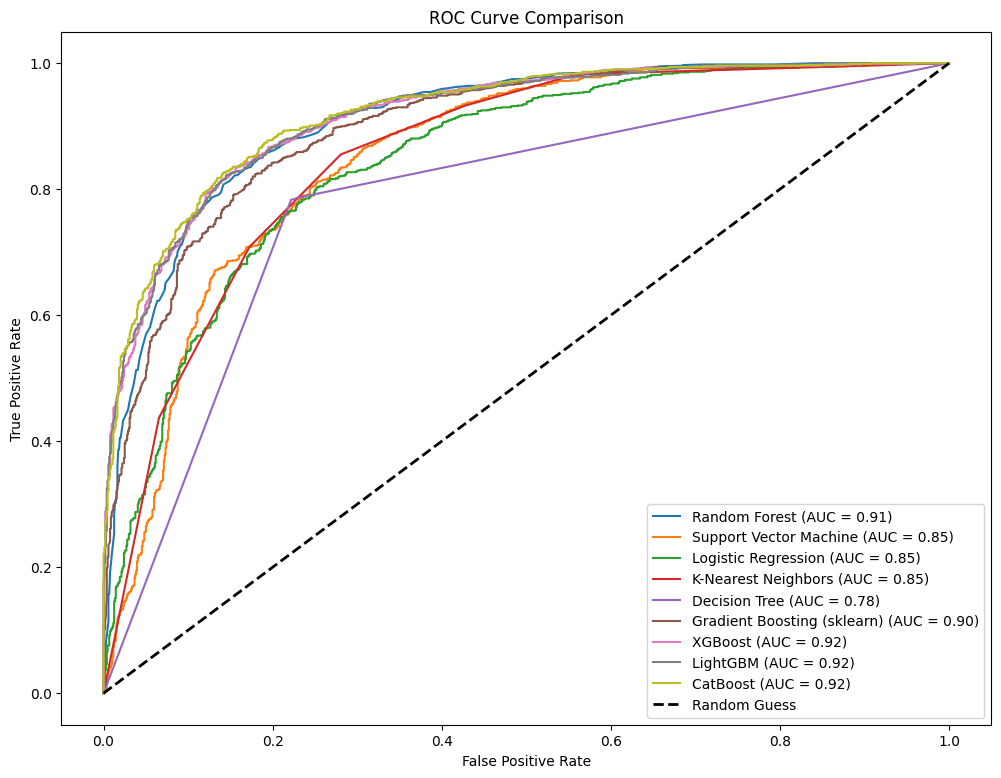

In [19]:
metrics_SMOTE = ROC_visualization(X_train, y_train, X_test, y_test)

In [20]:
print(metrics_SMOTE)

{'Random Forest': {'Accuracy': 0.8305905130687319, 'Precision': 0.8306427486670118, 'Recall': 0.8305905130687319, 'F1 Score': 0.830588607959164, 'ROC AUC': 0.910323379937455}, 'Support Vector Machine': {'Accuracy': 0.7754114230396902, 'Precision': 0.7776899355931354, 'Recall': 0.7754114230396902, 'F1 Score': 0.7750041246746961, 'ROC AUC': 0.8522790849360823}, 'Logistic Regression': {'Accuracy': 0.7725072604065828, 'Precision': 0.7742191438408497, 'Recall': 0.7725072604065828, 'F1 Score': 0.7721998934553882, 'ROC AUC': 0.8464987868683772}, 'K-Nearest Neighbors': {'Accuracy': 0.78702807357212, 'Precision': 0.7926658106251275, 'Recall': 0.78702807357212, 'F1 Score': 0.786074650408166, 'ROC AUC': 0.8544232681362943}, 'Decision Tree': {'Accuracy': 0.7807357212003873, 'Precision': 0.780754365960054, 'Recall': 0.7807357212003873, 'F1 Score': 0.7807360807885544, 'ROC AUC': 0.7811461821262462}, 'Gradient Boosting (sklearn)': {'Accuracy': 0.8146176185866408, 'Precision': 0.8168204291715278, 'Rec

/Users/yanhanjun/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [10:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


/Users/yanhanjun/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [10:51:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151
Random Forest: {'Accuracy': 0.7796730632551528, 'Precision': 0.7673942114427404, 'Recall': 0.7796730632551528, 'F1 Score': 0.770586579768011, 'ROC AUC': 0.8094628593318873}
Support Vector Machine: {'Accuracy': 0.7803837953091685, 'Precision': 0.7648666920599939, 'Recall': 0.7803837953091685, 'F1 Score': 0.7662244293216177, 'ROC AUC': 0.7845069912150373}
Logistic Regression: {'Accuracy': 0.7803837953091685, 'Precision': 0.7700118671526949, 'Re

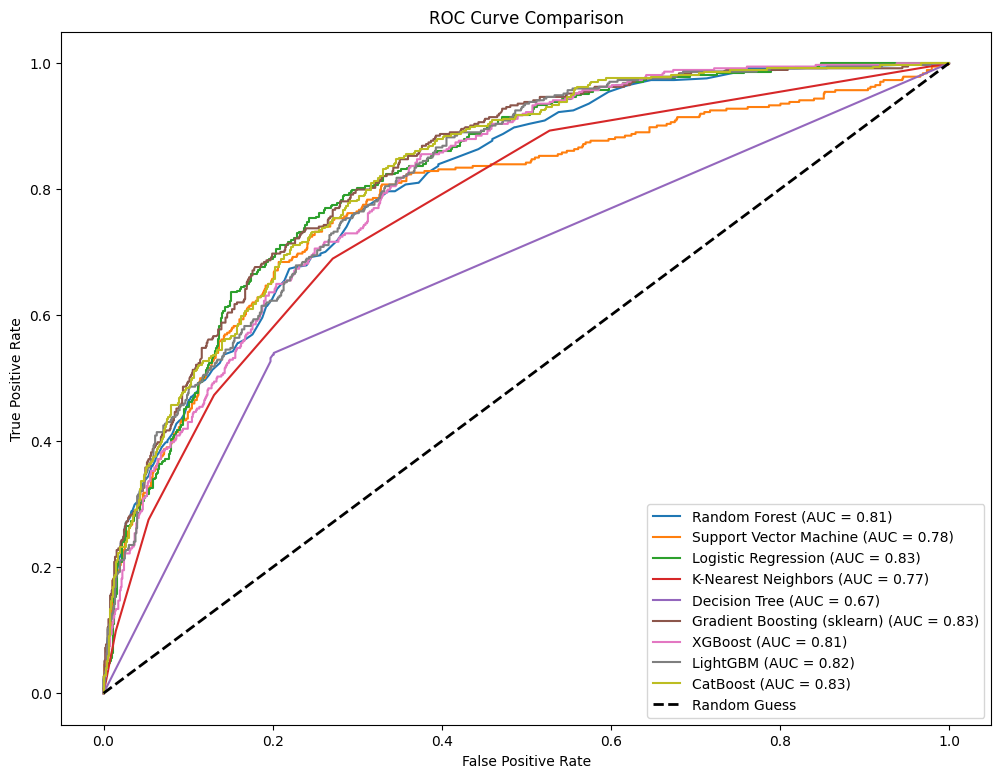

In [21]:
metrics_without_SMOTE = ROC_visualization(X_without_SMOTE_train, y_without_SMOTE_train, X_without_SMOTE_test, y_without_SMOTE_test)

In [22]:
print(metrics_SMOTE)

{'Random Forest': {'Accuracy': 0.8305905130687319, 'Precision': 0.8306427486670118, 'Recall': 0.8305905130687319, 'F1 Score': 0.830588607959164, 'ROC AUC': 0.910323379937455}, 'Support Vector Machine': {'Accuracy': 0.7754114230396902, 'Precision': 0.7776899355931354, 'Recall': 0.7754114230396902, 'F1 Score': 0.7750041246746961, 'ROC AUC': 0.8522790849360823}, 'Logistic Regression': {'Accuracy': 0.7725072604065828, 'Precision': 0.7742191438408497, 'Recall': 0.7725072604065828, 'F1 Score': 0.7721998934553882, 'ROC AUC': 0.8464987868683772}, 'K-Nearest Neighbors': {'Accuracy': 0.78702807357212, 'Precision': 0.7926658106251275, 'Recall': 0.78702807357212, 'F1 Score': 0.786074650408166, 'ROC AUC': 0.8544232681362943}, 'Decision Tree': {'Accuracy': 0.7807357212003873, 'Precision': 0.780754365960054, 'Recall': 0.7807357212003873, 'F1 Score': 0.7807360807885544, 'ROC AUC': 0.7811461821262462}, 'Gradient Boosting (sklearn)': {'Accuracy': 0.8146176185866408, 'Precision': 0.8168204291715278, 'Rec